### Codio Activity 13.8: End to End Classification Problem

**Expected Time = 90 minutes**

**Total Points = 85**

This example leads you through an end-to-end analysis of a classification algorithm using `LogisticRegression`. You will perform some brief exploratory data analysis (EDA). Then, you will construct a feature engineering, selection, and model pipeline. Finally, you will explore the mistakes your models make and compare different classification metrics.

### Index

- [Problem 1](#-Problem-1)
- [Problem 2](#-Problem-2)
- [Problem 3](#-Problem-3)
- [Problem 4](#-Problem-4)
- [Problem 5](#-Problem-5)
- [Problem 6](#-Problem-6)
- [Problem 7](#-Problem-7)
- [Problem 8](#-Problem-8)
- [Problem 9](#-Problem-9)
- [Problem 10](#-Problem-10)


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

### The Data

This data is originally from the IBM and contains information on a telecommunications company customer subscriptions.  Your task is to predict the customers who will Churn.  The data is loaded, displayed, and split below.

In [30]:
df = pd.read_csv('data/wa_churn.csv')

In [31]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [33]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype('float')

In [34]:
df = df.dropna()

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Churn', 'customerID'], axis = 1), df['Churn'], random_state = 442, stratify = df['Churn'])

[Back to top](#-Index)

### Problem 1

### `make_column_selector`

**5 Points**

To begin, you may want to incorporate many of the categorical features here.  Rather than writing a list of names, you can use the `make_column_selector` to select features by datatype.  For example:

```python
make_column_selector(dtype_include=object)
```

will select all columns with `object` datatype.  This selector will replace the list of column names in the `make_column_transformer`.  

Create a selector object to select the columns with object datatype below.  Assign this to `selector`.

In [59]:
### GRADED

selector = ''

### BEGIN SOLUTION
selector = make_column_selector(dtype_include=object)
### END SOLUTION

# Answer check
selector

In [60]:
### BEGIN HIDDEN TESTS
selector_ = make_column_selector(dtype_include=object)
#
#
#
assert selector.dtype_include == selector_.dtype_include
### END HIDDEN TESTS

[Back to top](#-Index)

### Problem 2

#### Column Transformer

**5 Points**

Use your `selector` object in the `make_column_transformer` to select the `object` datatypes and apply the `OneHotEncoder` with `drop = first` and the `StandardScaler` to all other features.  Assign this to `transformer` below.



In [62]:
### GRADED
transformer = ''

### BEGIN SOLUTION
transformer = make_column_transformer((OneHotEncoder(drop = 'first'), selector),
                                     remainder = StandardScaler())
### END SOLUTION

# Answer check
transformer

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000018BD63EAE00>)])

In [63]:
### BEGIN HIDDEN TESTS
transformer_ = make_column_transformer((OneHotEncoder(drop = 'first'), selector),
                                     remainder = StandardScaler())
#
#
#
assert type(transformer.remainder) == type(transformer_.remainder)
assert transformer.get_params()['onehotencoder__drop'] == transformer_.get_params()['onehotencoder__drop']
### END HIDDEN TESTS

[Back to top](#-Index)

### Problem 3

#### Feature Extractor

**5 Points**

Just as in our earlier assignment you can use `LogisticRegression` with `l1` penalty to select features for the model.  Below, create a `SelectFromModel` object that uses a `LogisticRegression` estimator with `penalty = 'l1'`, solver of `liblinear` and `random_state = 42`.  Assign your transformer as `extractor` below.

In [40]:
### GRADED
extractor = ''

### BEGIN SOLUTION
extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42))
### END SOLUTION

# Answer check
extractor

SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear'))

In [41]:
### BEGIN HIDDEN TESTS
extractor_ = SelectFromModel(LogisticRegression(penalty='l1', solver = 'libinear', random_state = 42))
#
#
#
assert extractor.estimator.penalty == extractor_.estimator.penalty
assert extractor.estimator.random_state == extractor_.estimator.random_state
### END HIDDEN TESTS

[Back to top](#-Index)

### Problem 4

#### Pipeline with Estimator

**10 Points**

Now, build a pipeline `lgr_pipe` with named steps `transformer`, `selector`, and `lgr` that implement the column transformer, feature selector, (both from above) and a `LogisticRegression` estimator with `random_state = 42` and `max_iter = 1000`.  

Fit the pipeline on the training data and determine the score on the test data.  Assign the accuracy as a float to `pipe_1_acc` below. 

In [42]:
### GRADED

lgr_pipe = ''
pipe_1_acc = ''

### BEGIN SOLUTION
lgr_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])

lgr_pipe.fit(X_train, y_train)

pipe_1_acc = lgr_pipe.score(X_test, y_test)
### END SOLUTION

# Answer check
lgr_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000018BD633CA00>)])),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('lgr', LogisticRegression(max_iter=1000, random_state=42))])

In [43]:
### BEGIN HIDDEN TESTS
lgr_pipe_ = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])

lgr_pipe_.fit(X_train, y_train)

pipe_1_acc_ = lgr_pipe_.score(X_test, y_test)
#
#
#
assert list(lgr_pipe_.named_steps.keys()) == list(lgr_pipe.named_steps.keys())
assert pipe_1_acc_ == pipe_1_acc
### END HIDDEN TESTS

[Back to top](#-Index)

### Problem 5

#### Comparison to Baseline

**10 Points**

Use the `value_counts` method to determine the baseline score by choosing the majority class as your predictions.  Did your pipeline outperform the baseline model?  Answer `yes` or `no` as a string to `ans5` below.

In [44]:
### GRADED

ans5 = ''
### BEGIN SOLUTION
ans5 = 'yes'
# y_test.value_counts(normalize = True)
### END SOLUTION

### ANSWER TEST
print(ans5)

yes


In [45]:
### BEGIN HIDDEN TESTS
ans5_ = 'yes'
#
#
#
assert ans5 == ans5_
### END HIDDEN TESTS

[Back to top](#-Index)

### Problem 6

### Confusion Matrix and ROC Curve

**10 Points**

Examine both the confusion matrix and ROC curve using the cell below.  Create a 1 row by 2 column subplot object and place the confusion matrix on the left and ROC curve on the right.  Use these to determine the number of false positives and false negatives on the test data.  Assign as an integer to `fp` and `fn` below.  Also, use the `RocCurveDisplay` legend to determine the AUC score.  Assign this as a float with two decimal places to `auc` below. 

(126, 194, 0.86)

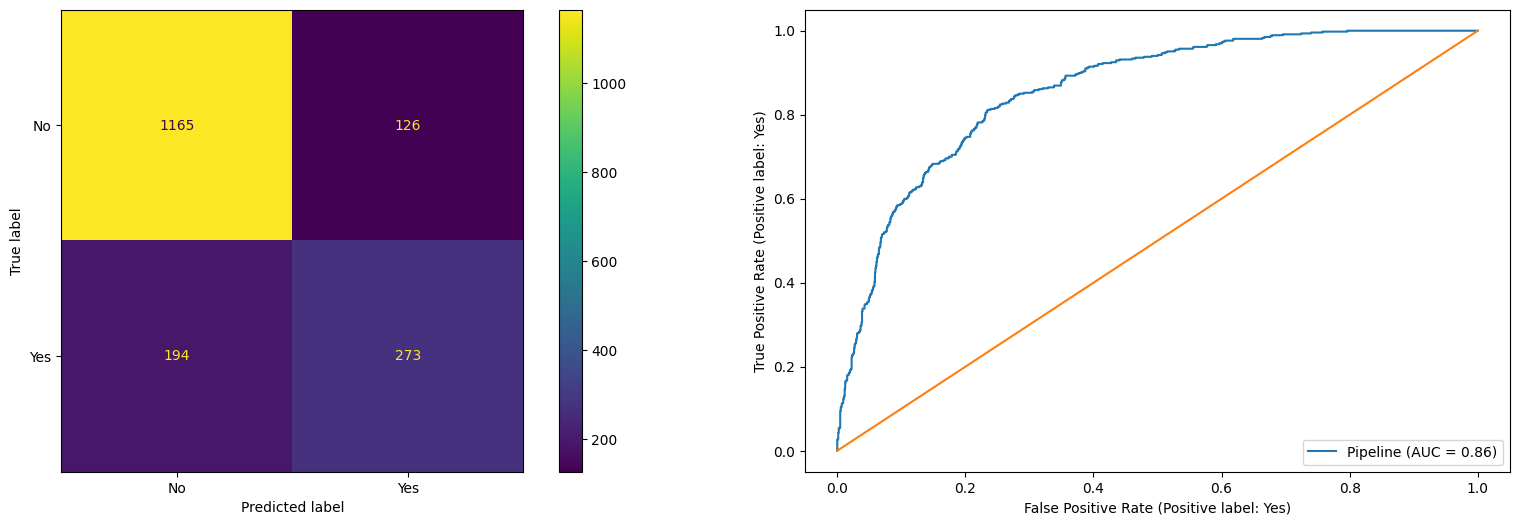

In [65]:
### GRADED

fp = ''
fn = ''
auc = ''

### BEGIN SOLUTION
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))
fp = 126
fn = 194
auc = 0.86
### END SOLUTION

### ANSWER CHECK
fp, fn, auc

In [47]:
### BEGIN HIDDEN TESTS
fp_ = 126
fn_ = 194
auc_ = 0.86
#
#
#
assert fp == fp_
assert fn == fn_
assert auc == auc_
### END HIDDEN TESTS

[Back to top](#-Index)

### Problem 7

#### What Really Matters

**10 Points**

You see above that you should have 194 False Negatives and 126 False Positives.  Suppose you want to implement an intervention to attempt turning over customers.  To use your classifier, this means being sure about targeting the customers you expect to churn -- in other words minimize the False Negatives.  Use the `predict_proba` method to select the probabilities of the `No` class.  Assign this as an array to `no_probs` below.

In [48]:
### GRADED

no_probs = ''
### BEGIN SOLUTION
no_probs = lgr_pipe.predict_proba(X_test)[:, 0]
### END SOLUTION

### ANSWER CHECK
no_probs[:5]

array([0.6712121 , 0.6102876 , 0.92346163, 0.97987776, 0.77035729])

In [49]:
### BEGIN HIDDEN TESTS
no_probs_ = lgr_pipe.predict_proba(X_test)[:, 0]
#
#
#
np.testing.assert_array_equal(no_probs, no_probs_)
### END HIDDEN TESTS

[Back to top](#-Index)

### Problem 8

#### Only target customers with high probability

**10 Points**

Even though our classifier is doing better than the baseline, it is still making a high number of mistakes.  Let's only look at the labels for `No` where you are better than 80% sure they are `No`'s.  Select these from your `no_probs` and assign as an array to `high_prob_no` below.

In [50]:
### GRADED

high_prob_no = ''

### BEGIN SOLUTION
high_prob_no = no_probs[no_probs > 0.8]
### END SOLUTION

### ANSWER CHECK
high_prob_no[:5]

array([0.92346163, 0.97987776, 0.93124674, 0.99276972, 0.94668556])

In [51]:
### BEGIN HIDDEN TESTS
high_prob_no_ = no_probs_[no_probs_ > 0.8]
#
#
#
np.testing.assert_array_equal(high_prob_no, high_prob_no_)
### END HIDDEN TESTS

[Back to top](#-Index)

### Problem 9

#### Number of Predictions

**10 Points**

How many datapoints had probability greater than 80% of `No`?  What percent of the test data is this?  What percent of the original test data set `No` values is this?  Assign your answer as a float to `percent_of_test_data` and `percent_of_no` below. 


In [52]:
### GRADED

percent_of_test_data = ''
percent_of_no = ''

### BEGIN SOLUTION
percent_of_test_data = len(high_prob_no)/len(y_test)
percent_of_no = len(high_prob_no)/sum(y_test == 'No')

### END SOLUTION

### ANSWER CHECK
print(percent_of_test_data)
print(percent_of_no)

0.5085324232081911
0.6924864446165763


In [53]:
### BEGIN HIDDEN TESTS
high_prob_percent_ = len(high_prob_no)/len(X_test)
#
#
#
assert percent_of_test_data == high_prob_percent_
### END HIDDEN TESTS

[Back to top](#-Index)

### Problem 10

#### Important Features

**10 Points**

Now, let us explore the coefficients of the model.  Because the data were scaled, we can think about the coefficients as speaking to a relative feature importance.  Extract the coefficients from your model and sort their absolute values from greatest to least.  Create a DataFrame called `coef_df` that contains the feature name and coefficient. The results begin as shown below:

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>feature</th>      <th>coefs</th>    </tr>  </thead>  <tbody>    <tr>      <th>14</th>      <td>Contract_Two year</td>      <td>1.321160</td>    </tr>    <tr>      <th>20</th>      <td>tenure</td>      <td>1.301754</td>    </tr>    <tr>      <th>9</th>      <td>TechSupport_No internet service</td>      <td>0.753071</td>    </tr>    <tr>      <th>13</th>      <td>Contract_One year</td>      <td>0.701108</td>    </tr>    <tr>      <th>5</th>      <td>InternetService_Fiber optic</td>      <td>0.679121</td>    </tr>  </tbody></table>

In [54]:
### GRADED

coef_df = ''

### BEGIN SOLUTION
feature_names = lgr_pipe.named_steps['transformer'].get_feature_names_out() 
selected_features =feature_names[ [int(i[1:]) for i in lgr_pipe.named_steps['selector'].get_feature_names_out()]]
clean_names = [i.split('__')[-1] for i in selected_features]
coef_df = pd.DataFrame({'feature': clean_names, 'coefs': lgr_pipe.named_steps['lgr'].coef_[0]})
coef_df['coefs'] = coef_df['coefs'].apply(abs)
coef_df = coef_df.sort_values(by = 'coefs', ascending = False)
### END SOLUTION

### ANSWER CHECK
coef_df.head()

,feature,coefs
14,Contract_Two year,1.321160
20,tenure,1.301754
9,TechSupport_No internet service,0.753071
13,Contract_One year,0.701108
5,InternetService_Fiber optic,0.679121


In [55]:
### BEGIN HIDDEN TESTS
feature_names_ = lgr_pipe_.named_steps['transformer'].get_feature_names_out() 
selected_features_ = feature_names_[ [int(i[1:]) for i in lgr_pipe_.named_steps['selector'].get_feature_names_out()]]
clean_names_ = [i.split('__')[-1] for i in selected_features_]
coef_df_ = pd.DataFrame({'feature': clean_names_, 'coefs': lgr_pipe_.named_steps['lgr'].coef_[0]})
coef_df_['coefs'] = coef_df_['coefs'].apply(abs)
coef_df_ = coef_df_.sort_values(by = 'coefs', ascending = False)
#
#
#
pd.testing.assert_frame_equal(coef_df, coef_df_)
### END HIDDEN TESTS

Notice that you should have a higher percentage of No values in your predictions than how much of the data it is comprised of.  In other words, if you randomly selected 50% of the data, you would expect 50% of the No.  Here, by ranking our predictions by probabilities and only selecting those with higher probability we are able to identify almost 70% of the No.  This notion of *LIFT* is an alternative method to that of ROC for understanding the quality of predictions, particularly if you have finite resources to expend.  If you are interested read more [here](https://www.ibm.com/docs/en/spss-statistics/24.0.0?topic=overtraining-cumulative-gains-lift-charts) and the `skplot` library has a straightforward visualization of the lift curve [here](https://scikit-plot.readthedocs.io/en/stable/metrics.html#scikitplot.metrics.plot_cumulative_gain).